# Spam Message Classification using Deep Learning

Natural language processing (NLP) for classifying SMS-messages as spam or not spam, based on the SMS contents.

## Install the Required Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

First, warnings are filtered to avoid cluttering of the notebook and %matplotlib inline style set

In [2]:
!pip install scikit-learn
!pip install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 6.8 MB/s 
     |████████████████████████████████| 831.4 MB 2.8 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which

Other required libraries not available in Google Colab are then installed

## Import Libraries

In [3]:
import time
import spacy
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import torch.optim as optim
import torch.nn as nn
from torchtext.legacy import data
from torchtext.legacy import datasets
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dropout, Dense
from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from collections import Counter

All the required libraries for the project are then imported

In [4]:
torch.cuda.is_available()

True

A check is to made to ensure cuda is available as the project works best on a GPU

## Load the Dataset

In [5]:
from google.colab import files
uploaded = files.upload()

Saving hamspam.csv to hamspam.csv


Using the above code, the required datasets can be uploaded, in this case being the _spam.csv_ dataset to be used in the Spam filtering part of the project.

In [6]:
sms_messages = pd.read_csv('hamspam.csv', encoding='latin1')
sms_messages = sms_messages.iloc[:, [0, 1]]
sms_messages.columns = ["label", "message"]
sms_messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


The above code reads the uploded dataset and prints the first five rows of the dataset.

In [7]:
# print the shape of the loaded dataset
sms_messages.shape

(5572, 2)

## Exploratory Data Analysis

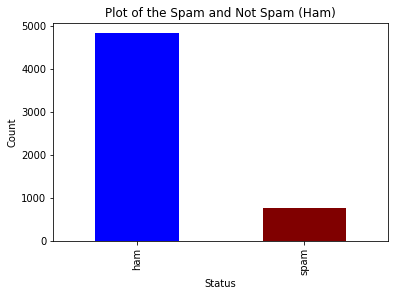

In [8]:
label_count = pd.value_counts(sms_messages["label"], sort=True)
label_count.plot(kind = "bar", color = ["blue", "maroon"])
plt.title("Plot of the Spam and Not Spam (Ham)")
plt.ylabel("Count")
plt.xlabel("Status")
plt.show()

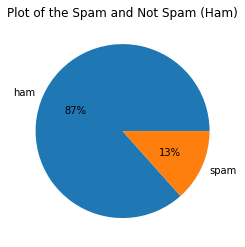

In [9]:
label_count = pd.value_counts(sms_messages["label"], sort=True)
label_count.plot(kind = "pie", autopct='%.0f%%')
plt.title("Plot of the Spam and Not Spam (Ham)")
plt.ylabel("")
plt.xlabel("")
plt.show()

The above plot is a visualization of the spam and ham in the dataset.

In [10]:
sms_messages.groupby("label").describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

After grouping the dataset by the labels (Spam and Ham), the above code shows the dataset description showing the count of each label.

In [11]:
sms_messages["length"] = sms_messages["message"].apply(len)
sms_messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


This cell implements feature engineering in message length. The message length is then compared against the identified labels as can be seen in the following code block and plot.

Text(0.5, 0, 'Message Length')

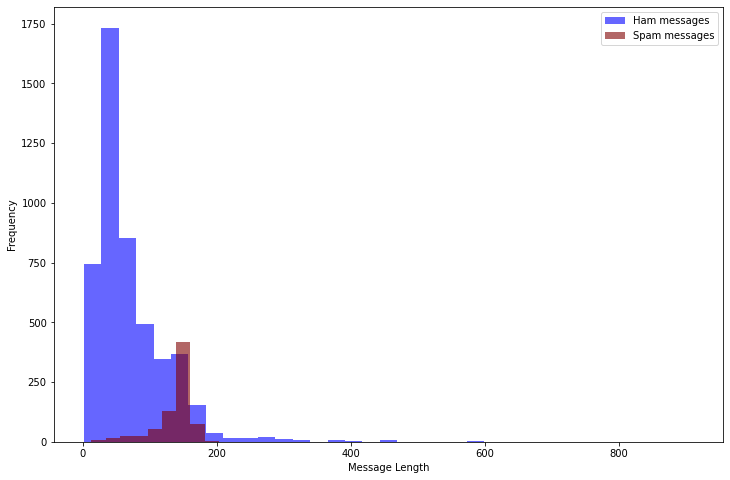

In [12]:
plt.figure(figsize=(12, 8))

sms_messages[sms_messages.label=="ham"].length.plot(
    bins=35, kind="hist", color="blue", label="Ham messages", alpha=0.6)
sms_messages[sms_messages.label=="spam"].length.plot(
    kind="hist", color="maroon", label="Spam messages", alpha=0.6)

plt.legend()
plt.xlabel("Message Length")

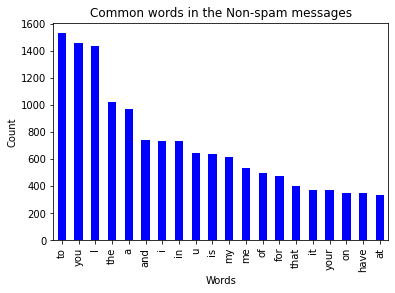

In [13]:
common_ham = Counter(" ".join(sms_messages[sms_messages["label"] == "ham"]["message"]).split()).most_common(20)
df_common_ham = pd.DataFrame.from_dict(common_ham)
df_common_ham = df_common_ham.rename(columns={0: "Word", 1: "Count"})

df_common_ham.plot.bar(legend = False, color = "blue")
y_pos = np.arange(len(df_common_ham["Word"]))
plt.xticks(y_pos, df_common_ham["Word"])
plt.title("Common words in the Non-spam messages")
plt.xlabel("Words")
plt.ylabel("Count")
plt.show()

A list of common words is then derived. The above plot shows a list of common words for the Non-spam dataset and their respective count.

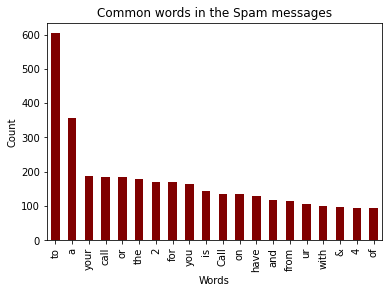

In [14]:
common_spam = Counter(" ".join(sms_messages[sms_messages["label"] == "spam"]["message"]).split()).most_common(20)
df_common_spam = pd.DataFrame.from_dict(common_spam)
df_common_spam = df_common_spam.rename(columns={0: "Word", 1: "Count"})

df_common_spam.plot.bar(legend = False, color = "maroon")
y_pos = np.arange(len(df_common_spam["Word"]))
plt.xticks(y_pos, df_common_spam["Word"])
plt.title("Common words in the Spam messages")
plt.xlabel("Words")
plt.ylabel("Count")
plt.show()

The bar plot above is a visualization for the most common words in the spam messages

## Build the Model

### Preprocessing

In [15]:
vocabular_size = 400
oov_token = "<OOV>"
max_length = 250
embedding_dimension = 16
number_of_epochs = 50

column_encoding = ({"ham": 0, "spam": 1})
sms_messages = sms_messages.replace(column_encoding)
sms_messages.head()

,label,message,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [16]:
X = sms_messages["message"]
Y = sms_messages["label"]

tokenizer = Tokenizer(num_words = vocabular_size, oov_token = oov_token)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

X = np.array(X)
y = np.array(Y)

In [17]:
X = pad_sequences(X, maxlen = max_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 7)

### Design the Model Architecture

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocabular_size, embedding_dimension, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 16)           6400      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 6,833
Trainable params: 6,833
Non-trainable params: 0
_________________________________________________________________


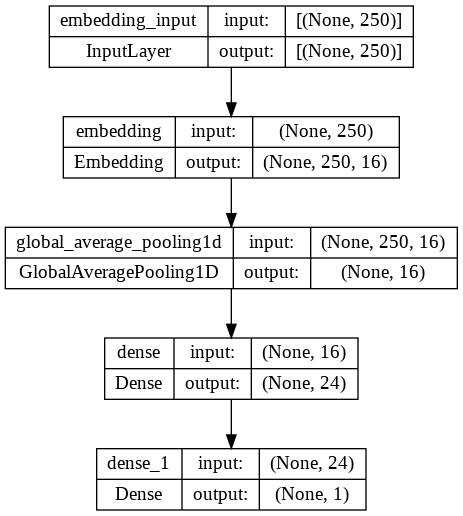

In [19]:
# Requires graphviz installed to work
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [20]:
history = model.fit(X_train, y_train, epochs = number_of_epochs, validation_data = (X_test, y_test), verbose = 2)

Epoch 1/50
131/131 - 3s - loss: 0.5457 - accuracy: 0.8423 - val_loss: 0.3931 - val_accuracy: 0.8693 - 3s/epoch - 26ms/step
Epoch 2/50
131/131 - 1s - loss: 0.3841 - accuracy: 0.8648 - val_loss: 0.3694 - val_accuracy: 0.8693 - 585ms/epoch - 4ms/step
Epoch 3/50
131/131 - 1s - loss: 0.3728 - accuracy: 0.8648 - val_loss: 0.3586 - val_accuracy: 0.8693 - 507ms/epoch - 4ms/step
Epoch 4/50
131/131 - 1s - loss: 0.3602 - accuracy: 0.8648 - val_loss: 0.3436 - val_accuracy: 0.8693 - 578ms/epoch - 4ms/step
Epoch 5/50
131/131 - 1s - loss: 0.3406 - accuracy: 0.8648 - val_loss: 0.3219 - val_accuracy: 0.8693 - 512ms/epoch - 4ms/step
Epoch 6/50
131/131 - 1s - loss: 0.3042 - accuracy: 0.8646 - val_loss: 0.2685 - val_accuracy: 0.8693 - 544ms/epoch - 4ms/step
Epoch 7/50
131/131 - 1s - loss: 0.2401 - accuracy: 0.8775 - val_loss: 0.1982 - val_accuracy: 0.9167 - 575ms/epoch - 4ms/step
Epoch 8/50
131/131 - 1s - loss: 0.1792 - accuracy: 0.9375 - val_loss: 0.1502 - val_accuracy: 0.9490 - 584ms/epoch - 4ms/step
Ep

In [21]:
result = model.evaluate(X_test, y_test)
loss = result[0]
accuracy = result[1]

print(f">> Accuracy: {accuracy * 100:.2f}%")

44/44 [==============================] - 0s 2ms/step - loss: 0.0556 - accuracy: 0.9864
>> Accuracy: 98.64%


### Save the Model

In [22]:
tf.keras.models.save_model(
    model,
    "model",
)

### Test Prediction

In [23]:
loaded_model = tf.keras.models.load_model(
    "model",
    custom_objects = None,
    compile = True,
)

sms_messages = pd.read_csv('hamspam.csv', encoding='latin1')
sms_messages = sms_messages.iloc[:, [1]]
sms_messages.columns = ["message"]
X = sms_messages["message"]

In [24]:
def get_predictions(txts):
    tokenizer = Tokenizer(num_words = 400, oov_token = "<OOV>")
    tokenizer.fit_on_texts(X)
    
    txts = tokenizer.texts_to_sequences(txts)
    txts = pad_sequences(txts, maxlen=250)
    preds = loaded_model.predict(txts)
    print(preds)
    
    if(preds[0] > 0.5):
        print("SPAM")
    else:
        print("NOT SPAM")

In [25]:
# Spam message
txts = ["Win a free iPhone worth $2,000 by 1st April 2023"]
get_predictions(txts)

1/1 [==============================] - 0s 69ms/step
[[0.5051657]]
SPAM


In [26]:
# Not Spam
txts = ["We shall be having our class tomorrow at noon."]
get_predictions(txts)

1/1 [==============================] - 0s 15ms/step
[[0.00057115]]
NOT SPAM


In [27]:
# Spam
txts = ["Our records show you overpaid for (a product or service). Kindly supply your bank routing and account number to receive your refund."]
get_predictions(txts)

1/1 [==============================] - 0s 15ms/step
[[0.99072474]]
SPAM


In [28]:
# Spam
txts = ["Hello. I hope your night was great."]
get_predictions(txts)

1/1 [==============================] - 0s 16ms/step
[[0.00013712]]
NOT SPAM


## Sentiment analysis

### Preparation of data

In [29]:
seed = 50
 
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda')
 
txt = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True)
 
labels = data.LabelField(dtype = torch.float)

In [30]:
train_data, test_data = datasets.IMDB.splits(txt, labels)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:01<00:00, 67.3MB/s]


In [31]:
train_data, valid_data = train_data.split(random_state = random.seed(seed))

In [32]:
num_words = 50_000

txt.build_vocab(train_data, 
                 max_size = num_words, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

labels.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.41MB/s]                           
100%|█████████▉| 399999/400000 [00:12<00:00, 30925.69it/s]


In [33]:
btch_size = 128

train_itr, valid_itr, test_itr = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = btch_size,
    sort_within_batch = True,
    device = device)

### Defining python sentiment analysis model

In [34]:
class RNN(nn.Module):
    def __init__(self, word_limit, dimension_embedding, dimension_hidden, dimension_output, num_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(word_limit, dimension_embedding, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(dimension_embedding, 
                           dimension_hidden, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(dimension_hidden * 2, dimension_output)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, len_txt):
        
        
        embedded = self.dropout(self.embedding(text))
               

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, len_txt.to('cpu'))
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                            
        return self.fc(hidden)

In [35]:
dimension_input = len(txt.vocab)
dimension_embedding = 100
dimension_hddn = 256
dimension_out = 1
layers = 2
bidirectional = True
droupout = 0.5
idx_pad = txt.vocab.stoi[txt.pad_token]

model = RNN(dimension_input, 
            dimension_embedding, 
            dimension_hddn, 
            dimension_out, 
            layers, 
            bidirectional, 
            droupout, 
            idx_pad)

In [36]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,310,857 trainable parameters


In [37]:
pretrained_embeddings = txt.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([50002, 100])


In [38]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-1.1588,  0.3673,  0.7110,  ..., -0.7083, -0.4158, -0.1077],
        [-0.5612,  1.1481, -0.7240,  ..., -0.0684, -0.1460, -1.1966],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 1.7765, -0.0532,  0.1279,  ..., -0.9538, -2.4998, -0.3557],
        [ 0.0564,  0.6554, -0.7455,  ..., -0.7413, -0.2614,  0.4580],
        [-0.0776,  0.1700,  0.3863,  ...,  0.1003, -0.2844,  0.4265]])

In [39]:
unique_id = txt.vocab.stoi[txt.unk_token]

model.embedding.weight.data[unique_id] = torch.zeros(dimension_embedding)
model.embedding.weight.data[idx_pad] = torch.zeros(dimension_embedding)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 1.7765, -0.0532,  0.1279,  ..., -0.9538, -2.4998, -0.3557],
        [ 0.0564,  0.6554, -0.7455,  ..., -0.7413, -0.2614,  0.4580],
        [-0.0776,  0.1700,  0.3863,  ...,  0.1003, -0.2844,  0.4265]])


In [40]:
optimizer = optim.Adam(model.parameters())

In [41]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

### Training of the model

In [42]:
def bin_acc(preds, y):
   
    predictions = torch.round(torch.sigmoid(preds))
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc

In [43]:
def train(model, itr, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for i in itr:
        
        optimizer.zero_grad()
        
        text, len_txt = i.text
        
        predictions = model(text, len_txt).squeeze(1)
        
        loss = criterion(predictions, i.label)
        
        acc = bin_acc(predictions, i.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(itr), epoch_acc / len(itr)

In [44]:
def evaluate(model, itr, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for i in itr:

            text, len_txt = i.text
            
            predictions = model(text, len_txt).squeeze(1)
            
            loss = criterion(predictions, i.label)
            
            acc = bin_acc(predictions, i.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(itr), epoch_acc / len(itr)

In [45]:
def epoch_time(start_time, end_time):
    used_time = end_time - start_time
    used_mins = int(used_time / 60)
    used_secs = int(used_time - (used_mins * 60))
    return used_mins, used_secs

In [46]:
num_epochs = 10

best_valid_loss = float('inf')

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1:02} of {num_epochs}...", end="")
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_itr, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_itr, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Took: {epoch_mins}m {epoch_secs}s')
    print(f'  Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'   Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Starting epoch 01 of 10...Took: 0m 30s
  Train Loss: 0.678 | Train Acc: 56.91%
   Val. Loss: 0.636 |  Val. Acc: 65.78%
Starting epoch 02 of 10...Took: 0m 30s
  Train Loss: 0.587 | Train Acc: 69.17%
   Val. Loss: 0.577 |  Val. Acc: 72.05%
Starting epoch 03 of 10...Took: 0m 31s
  Train Loss: 0.503 | Train Acc: 76.50%
   Val. Loss: 0.486 |  Val. Acc: 76.67%
Starting epoch 04 of 10...Took: 0m 31s
  Train Loss: 0.425 | Train Acc: 81.31%
   Val. Loss: 0.346 |  Val. Acc: 85.58%
Starting epoch 05 of 10...Took: 0m 31s
  Train Loss: 0.375 | Train Acc: 84.04%
   Val. Loss: 0.540 |  Val. Acc: 68.68%
Starting epoch 06 of 10...Took: 0m 31s
  Train Loss: 0.518 | Train Acc: 75.51%
   Val. Loss: 0.410 |  Val. Acc: 82.90%
Starting epoch 07 of 10...Took: 0m 31s
  Train Loss: 0.372 | Train Acc: 84.33%
   Val. Loss: 0.334 |  Val. Acc: 86.76%
Starting epoch 08 of 10...Took: 0m 31s
  Train Loss: 0.282 | Train Acc: 88.71%
   Val. Loss: 0.283 |  Val. Acc: 88.56%
Starting epoch 09 of 10...Took: 0m 31s
  Train L

### Testing sentiment analysis model

In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_itr, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.343 | Test Acc: 85.79%


In [ ]:
nlp = spacy.load('en_core_web_sm')

def pred(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [txt.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

In [ ]:
def formatted_sentiment(sentiment_value):
    if (sentiment_value < 0.2):
        sentiment_status = "Very Positive"
    elif (sentiment_value >= 0.2 and sentiment_value < 0.4):
        sentiment_status = "Positive"
    elif (sentiment_value >= 0.4 and sentiment_value < 0.6):
        sentiment_status = "Neutral"
    elif (sentiment_value >= 0.6 and sentiment_value < 0.8):
        sentiment_status = "Negative"
    else:
        sentiment_status = "Very Negative"
    return sentiment_status

In [ ]:
sentiment = formatted_sentiment(pred(model, "My friends are the best in the whole world"))
print(sentiment)

Very Positive


In [ ]:
sentiment = formatted_sentiment(pred(model, "She was 10 year old last year"))
print(sentiment)

Positive


In [ ]:
sentiment = formatted_sentiment(pred(model, "I like watching the movie with my girlfriend all the time"))
print(sentiment)

Negative


In [ ]:
sentiment = formatted_sentiment(pred(model, "I hate horror movies"))
print(sentiment)

Very Positive


In [ ]:
sentiment = formatted_sentiment(pred(model, "Most people hate bad vibes"))
print(sentiment)

Negative


### Blending spam filtering and sentiment analysis

In [ ]:
def get_analysis(model, sentence):
    sentiment_value = pred(model, sentence)
    sentiment_percentage = round(sentiment_value * 100, 2)

    if (sentiment_value < 0.2):
        sentiment_status = "Very Positive"
    elif (sentiment_value >= 0.2 and sentiment_value < 0.4):
        sentiment_status = "Positive"
    elif (sentiment_value >= 0.4 and sentiment_value < 0.6):
        sentiment_status = "Neutral"
    elif (sentiment_value >= 0.6 and sentiment_value < 0.8):
        sentiment_status = "Negative"
    else:
        sentiment_status = "Very Negative"

    tokenizer = Tokenizer(num_words = 400, oov_token = "<OOV>")
    tokenizer.fit_on_texts(X)
    
    txts = [sentence]
    txts = tokenizer.texts_to_sequences(txts)
    txts = pad_sequences(txts, maxlen=250)
    preds = loaded_model.predict(txts)
    
    if(preds[0] > 0.5):
        spam_status = "SPAM"
    else:
        spam_status = "NOT SPAM"

    print(f"-> Spam Status: {spam_status}")
    print(f"-> Sentiment Status: {sentiment_status} @ {round(sentiment_value, 2)}")

In [ ]:
txts = "Our records show you overpaid for (a product or service). Kindly supply your bank routing and account number to receive your refund."
get_analysis(model, txts)

1/1 [==============================] - 0s 16ms/step
-> Spam Status: SPAM
-> Sentiment Status: Very Negative @ 0.98


In [ ]:
txts = "Free entry in 2 a weekly competition to win FA Cup final tkts 21st May 2005"
get_analysis(model, txts)

1/1 [==============================] - 0s 16ms/step
-> Spam Status: SPAM
-> Sentiment Status: Very Positive @ 0.04


In [ ]:
sms_messages = pd.read_csv('hamspam.csv', encoding='latin1')
sms_messages = sms_messages.iloc[:, [0, 1]]
sms_messages.columns = ["label", "message"]
sms_messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
def sentiment_text(txt):
    sent = pred(model, txt)
    return formatted_sentiment(sent).lower()

In [ ]:
sentiment_column = []
for i, message in enumerate(sms_messages['message'], 1):
    sentiment_column.append(formatted_sentiment(pred(model, message)).lower())

print(sentiment_column[:5])

['very positive', 'negative', 'very positive', 'negative', 'negative']


In [ ]:
sms_messages["sentiment"] = sentiment_column

In [ ]:
sms_messages.head()

,label,message,sentiment
0,ham,"Go until jurong point, crazy.. Available only ...",very positive
1,ham,Ok lar... Joking wif u oni...,negative
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,very positive
3,ham,U dun say so early hor... U c already then say...,negative
4,ham,"Nah I don't think he goes to usf, he lives aro...",negative


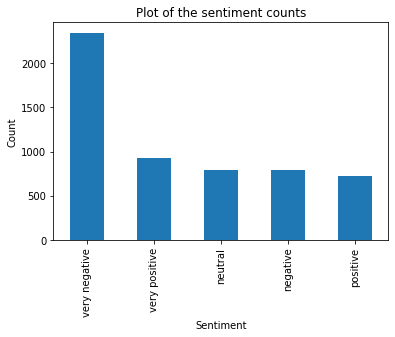

In [ ]:
label_count = pd.value_counts(sms_messages["sentiment"], sort=True)
label_count.plot(kind = "bar")
plt.title("Plot of the sentiment counts")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [ ]:
sms_messages = pd.read_csv('hamspam.csv', encoding='latin1')
sms_messages = sms_messages.iloc[:, [0, 1]]
sms_messages.columns = ["label", "message"]
sms_messages["sentiment"] = sentiment_column

ham_messages = sms_messages[sms_messages["label"] == "ham"]
ham_messages.head()

,label,message,sentiment
0,ham,"Go until jurong point, crazy.. Available only ...",very positive
1,ham,Ok lar... Joking wif u oni...,negative
3,ham,U dun say so early hor... U c already then say...,negative
4,ham,"Nah I don't think he goes to usf, he lives aro...",negative
6,ham,Even my brother is not like to speak with me. ...,neutral


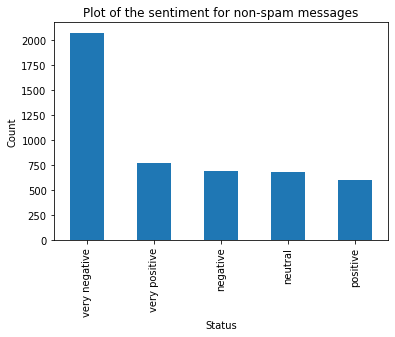

In [ ]:
label_count = pd.value_counts(ham_messages["sentiment"], sort=True)
label_count.plot(kind = "bar")
plt.title("Plot of the sentiment for non-spam messages")
plt.ylabel("Count")
plt.xlabel("Status")
plt.show()

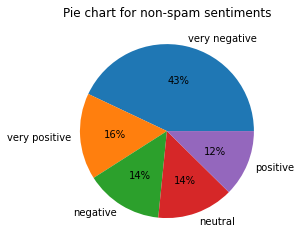

In [ ]:
label_count = pd.value_counts(ham_messages["sentiment"], sort=True)
label_count.plot(kind = "pie", autopct='%.0f%%')
plt.title("Pie chart for non-spam sentiments")
plt.ylabel("")
plt.xlabel("")
plt.show()

In [ ]:
spam_messages = sms_messages[sms_messages["label"] == "spam"]
spam_messages.head()

,label,message,sentiment
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,very positive
5,spam,FreeMsg Hey there darling it's been 3 week's n...,neutral
8,spam,WINNER!! As a valued network customer you have...,very positive
9,spam,Had your mobile 11 months or more? U R entitle...,very positive
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",negative


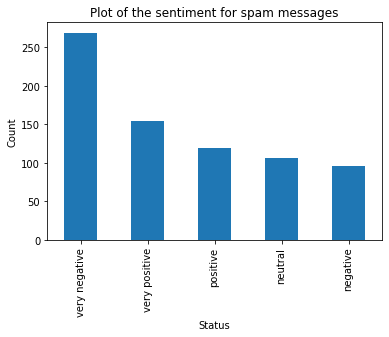

In [ ]:
label_count = pd.value_counts(spam_messages["sentiment"], sort=True)
label_count.plot(kind = "bar")
plt.title("Plot of the sentiment for spam messages")
plt.ylabel("Count")
plt.xlabel("Status")
plt.show()

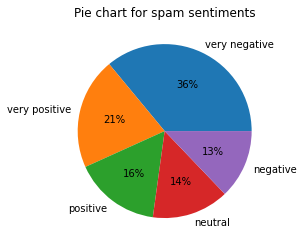

In [ ]:
label_count = pd.value_counts(spam_messages["sentiment"], sort=True)
label_count.plot(kind = "pie", autopct='%.0f%%')
plt.title("Pie chart for spam sentiments")
plt.ylabel("")
plt.xlabel("")
plt.show()

In [ ]:
# plot of sentiment in ham messages
# plot of sentiment in spam messages